## Building chatbot with multi tools using langgraph

### Aim is to create a chatbot with tool cappabilities from ARXIV, wikipedia search & some custom functions

In [4]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper



In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=400)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

print(arxiv.invoke("What is the latest research on LangChain?"))

Published: 2025-04-03
Title: A Review of Prototyping in XR: Linking Extended Reality to Digital Fabrication
Authors: Bixun Chen, Shaun Macdonald, Moataz Attallah, Paul Chapman, Rami Ghannam
Summary: Extended Reality (XR) has expanded the horizons of entertainment and social
life and shows great potential in the manufacturing industry. Prototyping in XR
can help designers make initial proposals and


In [7]:
print(arxiv.name)

arxiv


In [8]:
print(arxiv.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention laye


In [10]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=400)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

print(wikipedia.invoke("What is the latest research on LangChain?"))
#print(wikipedia.name)




Page: Wednesday (TV series)
Summary: Wednesday is an American supernatural mystery comedy television series based on the character Wednesday Addams by Charles Addams. Created by Alfred Gough and Miles Millar, it stars Jenna Ortega as the titular character, with Luis Guzmán and Catherine Zeta-Jones portraying her parents in the series. Four out of the eight episodes of the first season were directe


In [11]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


In [ ]:
#getting my tavily search tool
from langchain_community.tools import TavilySearchResults
# from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13044\580774280.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [13]:
tavily.invoke("What is the latest research on LangChain?")

[{'title': "LangChain : Why It's the Foundation of AI Agent Development in the ...",
  'url': 'https://medium.com/@takafumi.endo/langchain-why-its-the-foundation-of-ai-agent-development-in-the-enterprise-era-f082717c56d3',
  'content': 'The technical maturation has been equally impressive. Recent versions of LangChain have introduced enhanced streaming capabilities and expanded partner package support. LangGraph continues to evolve with advanced features that make sophisticated multi-agent workflows not just possible, but practical. The architectural migration from Pydantic v1 to v2 and separation of community packages demonstrates the kind of engineering discipline required for enterprise adoption. [...] The business model validation is equally compelling. Reports indicate LangChain achieved significant revenue growth, with some estimates suggesting figures around $8.5 million during their first year of monetization in 2024— with innovative pricing strategies like trace retention opti

In [14]:
## I will combine all tools in a LIST

tools = [arxiv, wikipedia, tavily]

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [16]:
from langchain_core.messages import HumanMessage, AIMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the latest research on LangChain?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GDkJB2ZI8UnCE12LqPztENd9', 'function': {'arguments': '{"query":"LangChain"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 219, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNLWjTtDTYoSjpAHQQ7BctAXC8t37', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--78fd821d-c7b5-4128-be56-c0e5420d4b70-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LangChain'}, 'id': 'call_GDkJB2ZI8UnCE12LqPztENd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 15, 'total_tokens': 234, 'input_token_details': {'audi

In [17]:
from pprint import pprint


In [18]:
llm_with_tools.invoke([HumanMessage(content=f"What is the latest research on LangChain?")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'LangChain'},
  'id': 'call_hDlrImM5NY0YJRfWYkk8a3eH',
  'type': 'tool_call'}]

In [19]:
## state schema
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

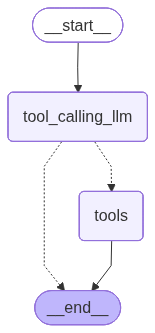

In [20]:
# Now let's create our CHATBOT using LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

## Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message is a tool call, then go to the tools node
    # Otherwise, go to the END node
    tools_condition, "tools")
builder.add_edge("tools", END)

graph = builder.compile()

## Run the graph
display(Image(graph.get_graph().draw_mermaid_png()))



In [21]:
messages = graph.invoke({"messages": [HumanMessage(content=f"What is the latest research on LangChain?")]})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest research on LangChain?
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_NjLSW4oa3MwSGivACgCSxWyl)
 Call ID: call_NjLSW4oa3MwSGivACgCSxWyl
  Args:
    query: LangChain
================================= Tool Message =================================
Name: arxiv

Published: 2025-01-27
Title: From Prompt Injections to SQL Injection Attacks: How Protected is Your LLM-Integrated Web Application?
Authors: Rodrigo Pedro, Daniel Castro, Paulo Carreira, Nuno Santos
Summary: Large Language Models (LLMs) have found widespread applications in various
domains, including web applications, where they facilitate human interaction
via chatbots with natural language inter
